In [1]:
%matplotlib inline
import os
import os.path as osp
import pandas as pd
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
import celldom
from celldom.core.experiment import Experiment
from celldom.config.experiment_config import get_exp_config_by_name

EXP_NAME = 'exp-20180217-G1-K562-control-01'
COUNT_DATA_DIR = osp.join(celldom.get_dataset_dir(), 'dataset06', 'manual_counting')
XLS_FILE = osp.join(COUNT_DATA_DIR, 'G1 35 K562 IMDM Tests - summary.xlsx')
OUTPUT_DIR = osp.join(celldom.get_data_dir(), 'output', '20181003-G1-full')
#OUTPUT_DIR = osp.join(celldom.get_data_dir(), 'output', '20181003-G1-full-bkp')

XLS_FILE, OUTPUT_DIR

('/lab/data/celldom/dataset/dataset06/manual_counting/G1 35 K562 IMDM Tests - summary.xlsx',
 '/lab/data/celldom/output/20181003-G1-full')

In [2]:
exp = Experiment(get_exp_config_by_name(EXP_NAME), OUTPUT_DIR)

In [3]:
!pip install xlrd
d = pd.read_excel(XLS_FILE, sheet_name=None)
d.keys()

You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


odict_keys(['Data Summary', 'Count Summary', 'Heatmap Sumary 0-63 hr', 'Test 2 Heatmap (0 hr)', 'Test 2 Heatmap (17 hr)', 'Test 2 Heatmap (41 hr)', 'Test 2 Heatmap (63 hr)', 'Heatmap Sumary 0-63 hr (3)', 'Heatmap Sumary 0-63 hr (2)'])

#### Load Validation Data

In [4]:
def get_true_count_data():
    df = (
        pd.read_excel(XLS_FILE, sheet_name='Count Summary', header=3)
        .assign(apt_num=lambda d: d['Apt'].apply(lambda v: '{:02d}'.format(v)))
        .assign(st_num=lambda d: d['Street'].apply(lambda v: '{:02d}'.format(v)))
        .drop(['Apt', 'Street'], axis=1)
        .reset_index(drop=True).set_index(['apt_num', 'st_num'])
    )
    df.columns.name = 'hours_str'
    df = df.stack().rename('cell_count').reset_index()
    df['hours'] = df['hours_str'].apply(lambda v: int(v.split()[0]))
    
    # Cell counts are floats at this point, and convert to int carefully
    assert (df['cell_count'].round() == df['cell_count']).all()
    df['cell_count'] = df['cell_count'].astype(int)
    
    # *IMPORTANT* transpose the st/apt interpretation intentionally reversed in processing to
    # comply with convention used in predicted counts
#     df = df.rename(columns={'apt_num': 'temp'})
#     df = df.rename(columns={'st_num': 'apt_num', 'temp': 'st_num'})
    
    return df

dft = get_true_count_data()
dft.info()
dft.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 5 columns):
apt_num       1512 non-null object
st_num        1512 non-null object
hours_str     1512 non-null object
cell_count    1512 non-null int64
hours         1512 non-null int64
dtypes: int64(2), object(3)
memory usage: 59.1+ KB


,apt_num,st_num,hours_str,cell_count,hours
0,00,31,0 hr,1,0
1,00,31,17 hr,1,17
2,00,31,41 hr,1,41
3,00,31,63 hr,1,63
4,00,30,0 hr,1,0


In [5]:
dft.groupby('hours').size()

hours
0     378
17    378
41    378
63    378
dtype: int64

In [6]:
dft['cell_count'].describe()

count    1512.000000
mean        2.600529
std         4.254535
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        40.000000
Name: cell_count, dtype: float64

In [7]:
dft['st_num'].max(), dft['apt_num'].max()

('31', '11')

#### Load Predicted Data

In [8]:
def get_pred_count_data():

    df = exp.get_data_store().get('apartment')

    df = df[['apt_num', 'st_num', 'acq_hours', 'cell_count']]
    df['hours_str'] = df['acq_hours'].apply(lambda v: '{} hr'.format(v))
    df['hours'] = df['acq_hours'].astype(int)
    df = df.drop(['acq_hours'], axis=1)

    # Group by apartment + time and compute median cell count (rounded)
    df = df.groupby(['apt_num', 'st_num', 'hours', 'hours_str'])['cell_count'].median()\
        .rename('cell_count').round().astype(int).reset_index()
    
    return df

dfp = get_pred_count_data()
dfp.info()
dfp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13314 entries, 0 to 13313
Data columns (total 5 columns):
apt_num       13314 non-null object
st_num        13314 non-null object
hours         13314 non-null int64
hours_str     13314 non-null object
cell_count    13314 non-null int64
dtypes: int64(2), object(3)
memory usage: 520.2+ KB


,apt_num,st_num,hours,hours_str,cell_count
0,00,00,0,0 hr,1
1,00,00,17,17 hr,4
2,00,00,41,41 hr,8
3,00,00,63,63 hr,20
4,00,00,71,71 hr,22


In [9]:
dfp.groupby('hours').size()

hours
0      1476
17     1479
41     1481
63     1477
71     1479
78     1480
88     1481
100    1479
117    1482
dtype: int64

In [10]:
dfp['cell_count'].describe()

count    13314.000000
mean         3.172375
std          9.111820
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max        105.000000
Name: cell_count, dtype: float64

In [11]:
pd.concat([
    dfp['st_num'].value_counts().sort_index(),
    dfp['apt_num'].value_counts().sort_index()
], axis=1)

,st_num,apt_num
00,423.0,284
01,423.0,279
02,423.0,288
03,423.0,279
04,423.0,288
05,423.0,279
06,423.0,287
07,423.0,279
08,423.0,288
09,423.0,279


### Merge

In [12]:
df = pd.merge(
    dft.rename(columns={'cell_count': 'true_ct'}), 
    dfp.rename(columns={'cell_count': 'pred_ct'}), 
    on=['apt_num', 'st_num', 'hours', 'hours_str'], 
    how='left'
)
df['delta_ct'] = df['pred_ct'] - df['true_ct']

if df['pred_ct'].isnull().any():
    df.info()
    mask = df['pred_ct'].notnull()
    n = len(df)
    print('Eliminating {} records of {} without predictions'.format(n - mask.sum(), n))
    df = df[mask.values]
    df['pred_ct'] = df['pred_ct'].astype(int)
    df['delta_ct'] = df['delta_ct'].astype(int)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1512 entries, 0 to 1511
Data columns (total 7 columns):
apt_num      1512 non-null object
st_num       1512 non-null object
hours_str    1512 non-null object
true_ct      1512 non-null int64
hours        1512 non-null int64
pred_ct      1508 non-null float64
delta_ct     1508 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 94.5+ KB
Eliminating 4 records of 1512 without predictions
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1508 entries, 0 to 1511
Data columns (total 7 columns):
apt_num      1508 non-null object
st_num       1508 non-null object
hours_str    1508 non-null object
true_ct      1508 non-null int64
hours        1508 non-null int64
pred_ct      1508 non-null int64
delta_ct     1508 non-null int64
dtypes: int64(4), object(3)
memory usage: 94.2+ KB


,apt_num,st_num,hours_str,true_ct,hours,pred_ct,delta_ct
0,00,31,0 hr,1,0,1,0
1,00,31,17 hr,1,17,1,0
2,00,31,41 hr,1,41,1,0
5,00,30,17 hr,1,17,1,0
6,00,30,41 hr,3,41,3,0


In [13]:
df['delta_ct'].value_counts().sort_index()

-8       1
-7       1
-6       1
-4       2
-3       3
-2       5
-1      36
 0    1419
 1      34
 2       5
 4       1
Name: delta_ct, dtype: int64

In [14]:
df['hours'].value_counts()

41    378
17    378
63    376
0     376
Name: hours, dtype: int64

In [15]:
# Total number of cells across array subset by hour
df.groupby('hours')[['pred_ct', 'true_ct']].sum()

,pred_ct,true_ct
hours,,
0,292,293
17,522,520
41,1039,1038
63,2035,2073


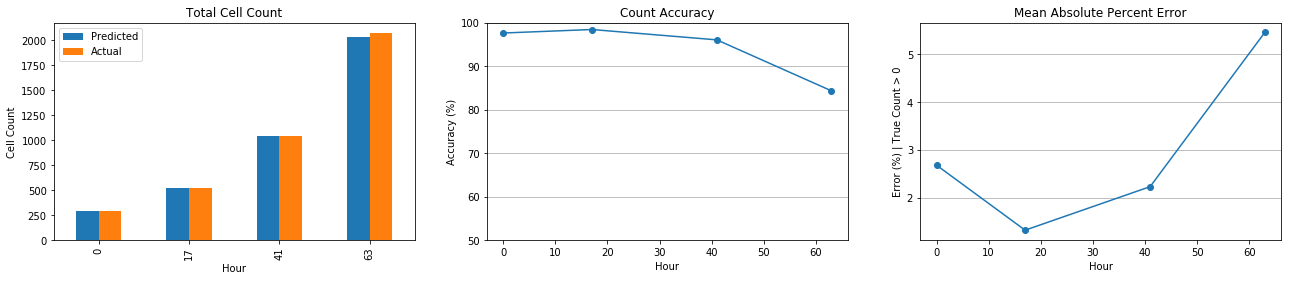

In [16]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(22, 4)

ax = df.groupby('hours')[['pred_ct', 'true_ct']].sum()\
    .rename(columns={'pred_ct': 'Predicted', 'true_ct': 'Actual'}).plot(kind='bar', ax=axs[0])
ax.set_title('Total Cell Count')
ax.set_ylabel('Cell Count')
ax.set_xlabel('Hour')

ax = df.groupby('hours').apply(lambda g: (g['delta_ct'] == 0).mean()).mul(100).plot(kind='line', style='o-', ax=axs[1])
ax.set_title('Count Accuracy')
ax.set_xlabel('Hour')
ax.set_ylabel('Accuracy (%)')
ax.yaxis.grid()
ax.set_ylim(50, 100)

def get_pct_error(g):
    g = g[g['true_ct'] > 0]
    return (g['delta_ct'].abs() / g['true_ct']).describe()
ax = df.groupby('hours').apply(get_pct_error)['mean'].mul(100).plot(style='o-', ax=axs[2])
ax.set_title('Mean Absolute Percent Error')
ax.set_xlabel('Hour')
ax.set_ylabel('Error (%) | True Count > 0')
ax.yaxis.grid()

In [17]:
(df[df['true_ct'] == 0]['pred_ct'] == 0).mean()

0.9798387096774194

In [18]:
df[df['true_ct'] == 0].groupby('hours').apply(lambda g: (g['pred_ct'] == 0).mean())

hours
0     1.000000
17    1.000000
41    1.000000
63    0.922481
dtype: float64

In [19]:
# Prediction difference distributions by hour
df.groupby('hours')['delta_ct'].describe(percentiles=[.05, .1, .25, .50, .75, .9, .95])

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
hours,,,,,,,,,,,,
0,376.0,-0.002660,0.154896,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17,378.0,0.005291,0.126044,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41,378.0,0.002646,0.295848,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
63,376.0,-0.101064,0.867425,-8.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0


In [20]:
def background_gradient(s, cmap='PuBu'):
    from matplotlib import colors
    normed = [.2 if x == 0 else (.4 if x < 50 else .8) for x in s]
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

dftbl = df.groupby('hours')['delta_ct'].value_counts().unstack().fillna(0).astype(int)
dftbl['Num Apartments'] = dftbl.sum(axis=1)
dftbl.columns.name = 'Count Difference'
dftbl.index.name = 'Hour'
dftbl.style\
    .set_caption('Count Differences<br> (- Prediction Low <------> Prediction High +)')\
    .apply(background_gradient, subset=[c for c in dftbl if c != 'Num Apartments'], cmap='Blues')\
    .background_gradient(cmap='Greens', subset='Num Apartments', low=.4, high=.6)

Count Difference,-8,-7,-6,-4,-3,-2,-1,0,1,2,4,Num Apartments
Hour,,,,,,,,,,,,
0,0,0,0,0,0,0,5,367,4,0,0,376
17,0,0,0,0,0,0,2,372,4,0,0,378
41,0,0,0,1,0,0,5,363,8,1,0,378
63,1,1,1,1,3,5,24,317,18,4,1,376


In [21]:
def background_gradient(s, cmap='PuBu'):
    from matplotlib import colors
    normed = [.2 if x == 0 else (.4 if x < .1 else .8) for x in s]
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

dftbl = df.groupby('hours')['delta_ct'].value_counts().unstack().fillna(0).astype(int)
dftbl = dftbl.divide(dftbl.sum(axis=1), 0)
dftbl.columns.name = 'Count Difference'
dftbl.index.name = 'Hour'
dftbl.style\
    .set_caption('Count Difference Percentages<br> (- Prediction Low <------> Prediction High +)')\
   .apply(background_gradient, cmap='Blues')\
   .format('{:.1%}')

Count Difference,-8,-7,-6,-4,-3,-2,-1,0,1,2,4
Hour,,,,,,,,,,,
0,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,1.3%,97.6%,1.1%,0.0%,0.0%
17,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.5%,98.4%,1.1%,0.0%,0.0%
41,0.0%,0.0%,0.0%,0.3%,0.0%,0.0%,1.3%,96.0%,2.1%,0.3%,0.0%
63,0.3%,0.3%,0.3%,0.3%,0.8%,1.3%,6.4%,84.3%,4.8%,1.1%,0.3%


In [22]:
df[(df['hours'] == 63) & (df['delta_ct'] == 1)].sort_values('true_ct')

,apt_num,st_num,hours_str,true_ct,hours,pred_ct,delta_ct
1383,10,01,63 hr,0,63,1,1
1327,10,15,63 hr,0,63,1,1
583,04,12,63 hr,0,63,1,1
679,05,19,63 hr,0,63,1,1
1379,10,02,63 hr,0,63,1,1
1231,09,07,63 hr,0,63,1,1
755,05,00,63 hr,1,63,2,1
1255,09,01,63 hr,1,63,2,1
1019,08,29,63 hr,1,63,2,1
887,07,30,63 hr,2,63,3,1


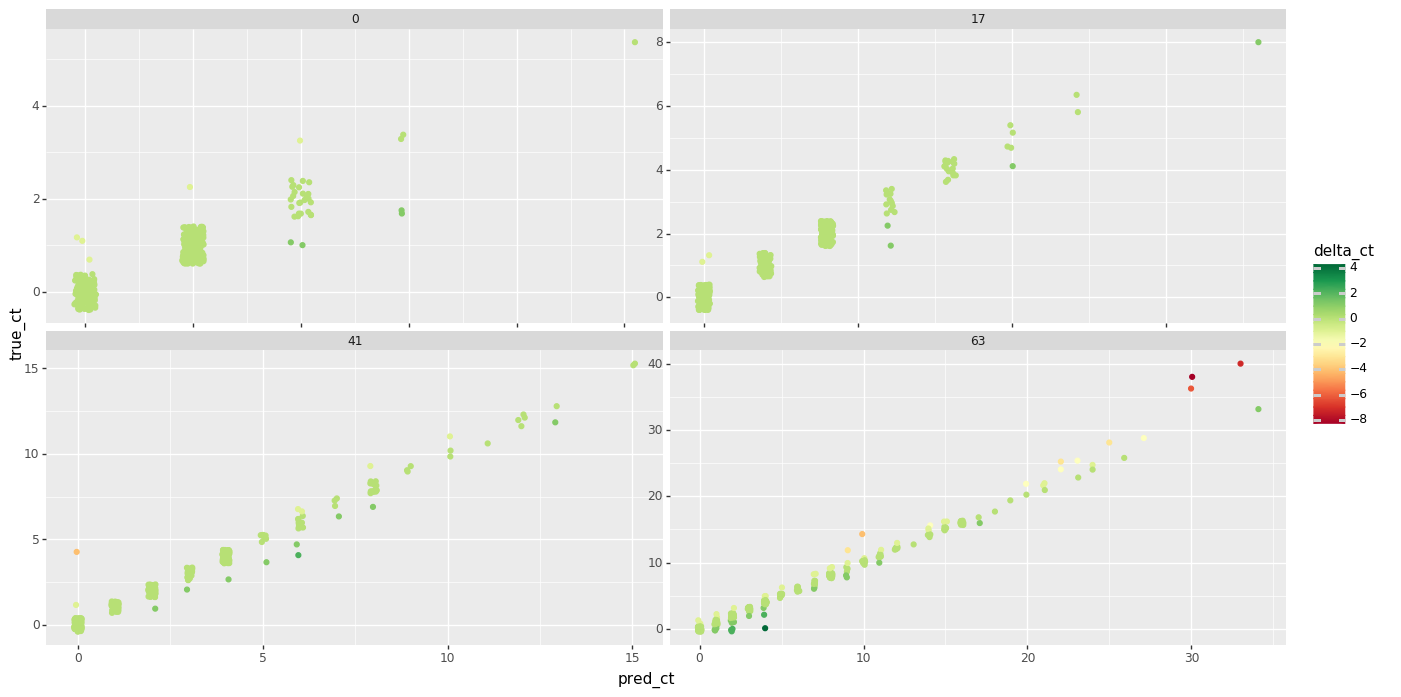

<ggplot: (8750460404102)>

In [23]:
(
    pn.ggplot(df, pn.aes(x='pred_ct', y='true_ct', fill='delta_ct', color='delta_ct')) +
    pn.geom_jitter(width=.1) +
    pn.facet_wrap('~hours', scales='free', ncol=2) +
    pn.scale_fill_cmap('RdYlGn') +
    pn.scale_color_cmap('RdYlGn') +
    pn.theme(figure_size=(16, 8))
)